In [8]:
import os
import findspark

# Set SPARK_HOME to the correct path
os.environ["SPARK_HOME"] = "/opt/homebrew/Cellar/apache-spark/3.5.3/libexec"
findspark.init()

from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .master("local[*]") \
    .getOrCreate()

# Test with a simple DataFrame
data = [("John", 30), ("Alice", 25), ("Bob", 35)]
df = spark.createDataFrame(data, ["Name", "Age"])
df.show()
spark.sparkContext.setLogLevel("ERROR")

+-----+---+
| Name|Age|
+-----+---+
| John| 30|
|Alice| 25|
|  Bob| 35|
+-----+---+



In [9]:
# import df_with_dow.csv/part-00000-2bd45c6f-2cf2-4333-81d8-96431e4c7041-c000.csv
df = spark.read.csv("df_with_dow.csv/part-00000-81cc640a-acde-44c7-bf1e-fdb9f666b20b-c000.csv", header=True, inferSchema=True)
df.show()

+-----------+------------------+-----------+------------+-------------------+------------+---------------+-------------+----------+--------------------+--------------------+------------+
|pickup_date|pickup_day_of_week|pickup_hour|dropoff_date|dropoff_day_of_week|dropoff_hour|passenger_count|trip_distance|RatecodeID|     pickup_location|    dropoff_location|total_amount|
+-----------+------------------+-----------+------------+-------------------+------------+---------------+-------------+----------+--------------------+--------------------+------------+
| 2019-06-01|          Saturday|          0|  2019-06-01|           Saturday|           0|              1|          2.0|         1|        Midtown East|        East Chelsea|        17.3|
| 2019-06-01|          Saturday|          0|  2019-06-01|           Saturday|           0|              1|         1.53|         1|        Clinton East|Upper West Side S...|        12.3|
| 2019-06-01|          Saturday|          0|  2019-06-01|        

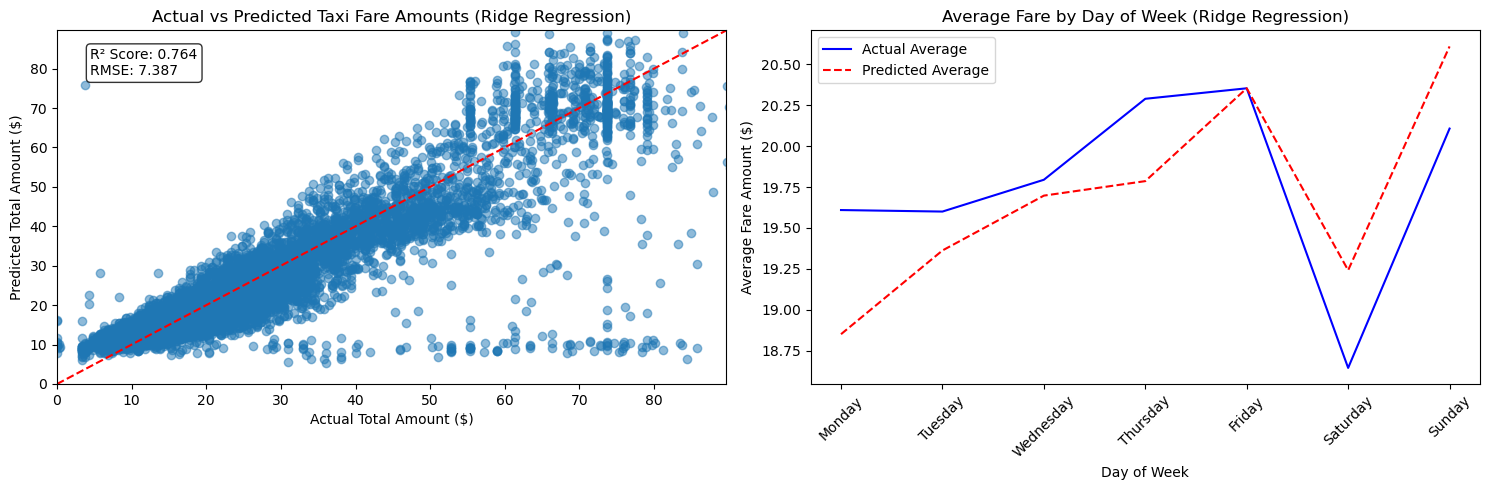


Feature Importances:
trip_distance: 3.4144
day_sin: 0.6274
day_cos: 0.3329
pickup_hour: 0.0617
dropoff_location_idx: 0.0227
passenger_count: 0.0194
pickup_location_idx: 0.0142


In [10]:
import matplotlib.pyplot as plt
import pandas as pd

from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import col, sin, cos, lit, radians

# Drop existing indexed columns if they exist
columns_to_drop = ["day_number", "day_sin", "day_cos", 
                  "pickup_location_idx", "dropoff_location_idx"]
for col_name in columns_to_drop:
    if col_name in df.columns:
        df = df.drop(col_name)

# Create day number (0-6)
day_indexer = StringIndexer(inputCol="pickup_day_of_week", outputCol="day_number")
df = day_indexer.fit(df).transform(df)

# Create cyclic features for days
df = df.withColumn("day_sin", sin(col("day_number") * 2.0 * 3.14159 / 7.0))
df = df.withColumn("day_cos", cos(col("day_number") * 2.0 * 3.14159 / 7.0))

# Convert categorical location columns to numeric
location_indexer = StringIndexer(inputCol="pickup_location", outputCol="pickup_location_idx")
df = location_indexer.fit(df).transform(df)
dropoff_indexer = StringIndexer(inputCol="dropoff_location", outputCol="dropoff_location_idx")
df = dropoff_indexer.fit(df).transform(df)

# Assembler remains the same
assembler = VectorAssembler(
    inputCols=["pickup_hour", "day_sin", "day_cos", "passenger_count", 
               "trip_distance", "pickup_location_idx", "dropoff_location_idx"],
    outputCol="features"
)
data = assembler.transform(df)

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

# Create and train the Ridge Regression model
# Note: RidgeRegression in PySpark is implemented through LinearRegression with an elasticNetParam of 0
ridge = LinearRegression(
    maxIter=10,
    regParam=0.1,  
    elasticNetParam=0.0,  # L2 regularization (Ridge)
    featuresCol="features",
    labelCol="total_amount"
)
model = ridge.fit(train_data)
predictions = model.transform(test_data)

# Create visualizations (same as before)
plt.figure(figsize=(15, 5))

# 1. Actual vs Predicted Plot
plt.subplot(1, 2, 1)

# Calculate the max value for axis limits (80% of maximum)
pred_pd = predictions.select("total_amount", "prediction").toPandas()
max_value = max(pred_pd["total_amount"].max(), pred_pd["prediction"].max())
axis_limit = 0.2 * max_value

# Create scatter plot with modified axes
plt.scatter(pred_pd["total_amount"], pred_pd["prediction"], alpha=0.5)
plt.plot([0, axis_limit], [0, axis_limit], 'r--')  # Perfect prediction line
plt.xlim(0, axis_limit)
plt.ylim(0, axis_limit)
plt.xlabel("Actual Total Amount ($)")
plt.ylabel("Predicted Total Amount ($)")
plt.title("Actual vs Predicted Taxi Fare Amounts (Ridge Regression)")
metrics_text = f'R² Score: {model.summary.r2:.3f}\nRMSE: {model.summary.rootMeanSquaredError:.3f}'
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Average Fare by Day of Week
plt.subplot(1, 2, 2)
day_avg = predictions.groupBy("pickup_day_of_week").agg({"total_amount": "avg", "prediction": "avg"}).toPandas()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_avg = day_avg.set_index('pickup_day_of_week').reindex(days_order)
plt.plot(day_avg.index, day_avg['avg(total_amount)'], 'b-', label='Actual Average')
plt.plot(day_avg.index, day_avg['avg(prediction)'], 'r--', label='Predicted Average')
plt.xticks(rotation=45)
plt.xlabel("Day of Week")
plt.ylabel("Average Fare Amount ($)")
plt.title("Average Fare by Day of Week (Ridge Regression)")
plt.legend()
plt.tight_layout()
plt.show()

# Print feature importances
feature_names = ["pickup_hour", "day_sin", "day_cos", "passenger_count", 
                "trip_distance", "pickup_location_idx", "dropoff_location_idx"]
importances = [(feature, abs(importance)) for feature, importance in zip(feature_names, model.coefficients)]
importances.sort(key=lambda x: x[1], reverse=True)
print("\nFeature Importances:")
for feature, importance in importances:
    print(f"{feature}: {importance:.4f}")